In [1]:
import os
import json
from docx import Document
from io import StringIO, BytesIO
import re

import pandas as pd
import json
import spacy
from nltk.corpus import stopwords

from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim import matutils, models
from gensim.models import CoherenceModel
import pyLDAvis.gensim

from docx import Document
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 3})

In [2]:
notebook_dir = os.getcwd()

In [3]:
event_type = 'ANIMAL'
with open(F'../data/sop_jsons/{event_type}.txt') as f:
    drugs = json.load(f)
f.close()
type(drugs)

dict

In [4]:
juris, roles, sops = list(), list(), list()
for juri, dct in drugs.items():
    for role, sop in dct.items():
        juris.append(juri)
        roles.append(role)
        sops.append(sop)
drugsdf = pd.DataFrame({'juri': juris, 'role': roles, 'sop': sops})
drugsdf.head(3)

,juri,role,sop
0,AB,call taker,[Animal bites – Just occurred or with a time d...
1,AB,info,"[Dogs at large, Advise Animal Control, Wild an..."
2,AB,dispatcher,"[Dogs at large, Assign a member if dog being a..."


In [5]:
drugs_calltaker = drugsdf[drugsdf['role'] == 'call taker']
drugs_dispatcher = drugsdf[drugsdf['role'] == 'dispatcher']

In [6]:
nlp = spacy.load("en_core_web_sm")
# stop_words = set(stopwords.words('english'))

In [7]:
remove = [
    "subject:",
    "writes:",
    "wrote:",
    "write:"
]
def multiple_replace(text, unwanted = remove):
    """
    Replace unwanted pattern with a space; return a string
    """ 
    reg = re.compile(f"({'|'.join(remove)})")
    return reg.sub(" ", text)
"(%s)" % "|".join(remove) == f"({'|'.join(remove)})"

True

In [8]:
def preprocess(strlist,
               min_token_len = 2,
               allowed_pos = ['ADV', 'ADJ', 'VERB', 'NOUN']): 
#     texts = ' '.join(strlist).lower()
    res = list()
    for string in strlist:
        text = string.lower()
        doc = nlp(text)
        res += [token.lemma_ for token in doc \
               if token.is_alpha \
               # Spacy considers 'call' as a stop word, which is not suitable for our case
               and not token.is_stop \
#                and token.text not in stop_words \              
               and token.pos_ in allowed_pos \
               and len(token.lemma_) > min_token_len]
    
    return ' '.join(res)

In [9]:
drugs_calltaker.shape

(16, 3)

In [10]:
['mama mele maso'.split(), 'ema ma mama'.split()]

[['mama', 'mele', 'maso'], ['ema', 'ma', 'mama']]

In [11]:
def get_dct_dtmatrix(sops):
    corpus = [sop.split() for sop in map(preprocess, sops)]
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    return doc_term_matrix, corpus, dictionary

In [12]:
# drugs_calltaker['sop']

In [13]:
doc_term_matrix, corpus, dictionary = get_dct_dtmatrix(drugs_calltaker['sop'])

In [14]:
corpus[0]

['animal',
 'bite',
 'occur',
 'time',
 'delay',
 'refer',
 'animal',
 'control',
 'require',
 'animal',
 'leave',
 'vehicle',
 'animal',
 'imminent',
 'distress',
 'abbotsford',
 'fire',
 'instance',
 'refer',
 'animal',
 'control',
 'dog',
 'large',
 'run',
 'large',
 'attack',
 'viciously',
 'pursue',
 'person',
 'domestic',
 'animal',
 'livestock',
 'create',
 'case',
 'refer',
 'animal',
 'control',
 'barking',
 'refer',
 'animal',
 'control',
 'deceased',
 'animal',
 'small',
 'animal',
 'refer',
 'animal',
 'control',
 'large',
 'animal',
 'municipal',
 'property',
 'refer',
 'public',
 'work',
 'yard',
 'highway',
 'contact',
 'neglect',
 'injure',
 'domestic',
 'animal',
 'refer',
 'animal',
 'control',
 'injured',
 'dog',
 'cat',
 'result',
 'fire',
 'refer',
 'fire',
 'animal',
 'include',
 'freeway',
 'snake',
 'create',
 'immediate',
 'danger',
 'refer',
 'animal',
 'control',
 'conservation',
 'office',
 'wild',
 'animal',
 'animal',
 'exhibit',
 'aggressive',
 'behaviour

In [15]:
def topics_with_coherence(doc_term_matrix, corpus, dictionary, texts, 
                          N = 10, passes = 20, coherence = 'c_v', random_state = 2020):
    num_topic, ldas, scores = list(), list(), list()
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    for n in range(1, N+1):
        lda = models.LdaModel(corpus = doc_term_matrix, 
                              id2word = dictionary, 
                              num_topics = n, 
                              passes = passes, 
                              random_state = random_state)
        coherence_model = CoherenceModel(
            model = lda, 
            texts = corpus, 
            dictionary = dictionary, 
            coherence = coherence)
        coherence_score = coherence_model.get_coherence()
#         mod = {'num_topic': n, 'model': lda, 'coherence_score': coherence_score}
#         res[f"num_topic={n}"] = [lda, coherence_score]
        num_topic.append(n)
        ldas.append(lda)
        scores.append(coherence_score)
    return pd.DataFrame({
        'num_topic':num_topic,
        'model': ldas,
        'coherence_score': scores
    })

In [16]:
drugs_call_coherence_cv = topics_with_coherence(doc_term_matrix, corpus, dictionary, drugs_calltaker['sop'])
drugs_call_coherence_cv

,num_topic,model,coherence_score
0,1,"LdaModel(num_terms=223, num_topics=1, decay=0....",0.436670
1,2,"LdaModel(num_terms=223, num_topics=2, decay=0....",0.455481
2,3,"LdaModel(num_terms=223, num_topics=3, decay=0....",0.430205
3,4,"LdaModel(num_terms=223, num_topics=4, decay=0....",0.503871
4,5,"LdaModel(num_terms=223, num_topics=5, decay=0....",0.388364
5,6,"LdaModel(num_terms=223, num_topics=6, decay=0....",0.413251
6,7,"LdaModel(num_terms=223, num_topics=7, decay=0....",0.465256
7,8,"LdaModel(num_terms=223, num_topics=8, decay=0....",0.477478
8,9,"LdaModel(num_terms=223, num_topics=9, decay=0....",0.470008
9,10,"LdaModel(num_terms=223, num_topics=10, decay=0...",0.433362


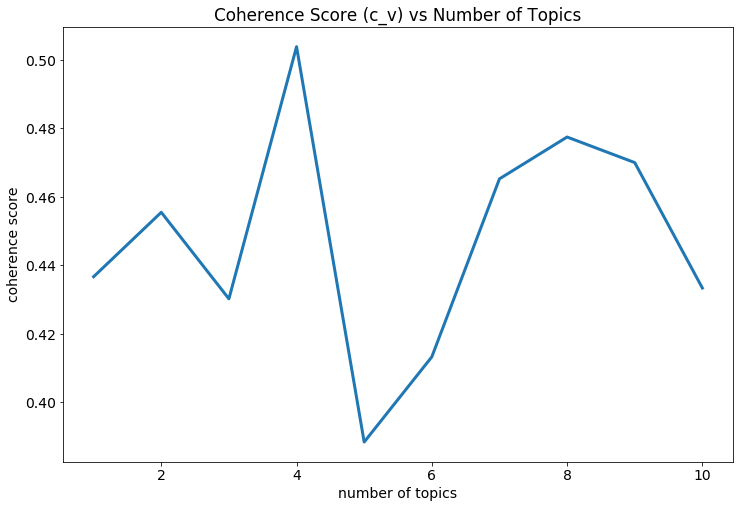

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.plot(drugs_call_coherence_cv.loc[:, 'num_topic'].values, 
        drugs_call_coherence_cv.loc[:, 'coherence_score'].values)
ax.set_xlabel('number of topics')
ax.set_ylabel('coherence score')
ax.set_title('Coherence Score (c_v) vs Number of Topics')
plt.show()

In [18]:
chosen_model_cv = list(drugs_call_coherence_cv.iloc[1:, :].sort_values('coherence_score')['model'])[-1]
print(chosen_model_cv)

LdaModel(num_terms=223, num_topics=4, decay=0.5, chunksize=2000)


In [19]:
chosen_model_cv.print_topics()

[(0,
  '0.107*"animal" + 0.070*"refer" + 0.062*"create" + 0.041*"public" + 0.025*"danger" + 0.024*"injure" + 0.023*"hour" + 0.023*"bylaw" + 0.019*"safety" + 0.019*"leave"'),
 (1,
  '0.037*"upgrade" + 0.037*"priority" + 0.029*"hold" + 0.019*"following" + 0.019*"enforcement" + 0.019*"apply" + 0.016*"file" + 0.016*"overnight" + 0.016*"arrangement" + 0.016*"shelter"'),
 (2,
  '0.005*"animal" + 0.005*"refer" + 0.005*"create" + 0.005*"public" + 0.005*"hour" + 0.005*"injure" + 0.005*"leave" + 0.005*"danger" + 0.005*"include" + 0.005*"conservation"'),
 (3,
  '0.140*"animal" + 0.063*"refer" + 0.051*"create" + 0.028*"control" + 0.021*"caller" + 0.016*"day" + 0.016*"public" + 0.015*"dog" + 0.014*"owner" + 0.013*"conservation"')]

In [20]:
model_cv_2 = list(drugs_call_coherence_cv[drugs_call_coherence_cv['num_topic'] == 2]['model'])[0]

In [21]:
def get_topic(model, doc):
    ppdoc = preprocess(doc)
    doc_term_arr = dictionary.doc2bow(ppdoc.split())
    return sorted(model[doc_term_arr], 
                  key = lambda x: x[1], 
                  reverse = True)[0][0]

In [22]:
sent = list(drugs_calltaker['sop'])#.append(['aa', 'bb'])
sent.append(['This is a test', 'to see if the model works'])
# sent

In [23]:
preprocess(list(drugs_calltaker['sop'])[2])

'animal bite create animal leave vehicle animal imminent danger create animal imminent danger refer bear activity create upgrade priority dog large run loose pose public safety risk create dog pose public safety risk refer spca barking unusual behaviour dog suspicious circumstance sop unusual behavior dog refer bylaw deceased animal create traffic hazard refer unsure consult watch commander cleanup residential street refer cleanup highway refer main road injure marine animal include seal whale refer rescue center animal leave hour neglect injure animal contact spca office animal include freeway snake livestock large create refer livestock wild animal animal exhibit aggressive behavior animal locate public area park school public child danger create animal injure public safety concern refer conservation wild animal report refer conservation'

In [24]:
ppsent = preprocess(sent[1])
doc_term_arr = dictionary.doc2bow(ppsent.split())
chosen_model_cv[doc_term_arr]
# doc_term_arr

[(0, 0.9945328)]

In [25]:
list(map(lambda x: get_topic(chosen_model_cv, list(x)), sent))

[3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1]

In [26]:
# umass_6 = list(drugs_call_coherence_umass[drugs_call_coherence_umass['num_topic'] == 4]['model'])[0]
# print(umass_6)
# list(map(lambda x: get_topic(umass_6, list(x)), sent))

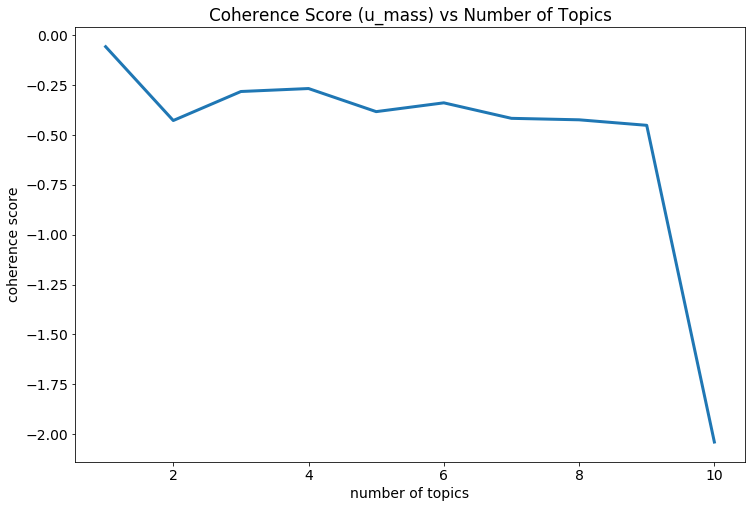

In [27]:
drugs_call_coherence_umass = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                                   drugs_calltaker['sop'], coherence = 'u_mass')
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.plot(drugs_call_coherence_umass.loc[:, 'num_topic'].values, 
        drugs_call_coherence_umass.loc[:, 'coherence_score'].values)
ax.set_xlabel('number of topics')
ax.set_ylabel('coherence score')
ax.set_title('Coherence Score (u_mass) vs Number of Topics')
plt.show()

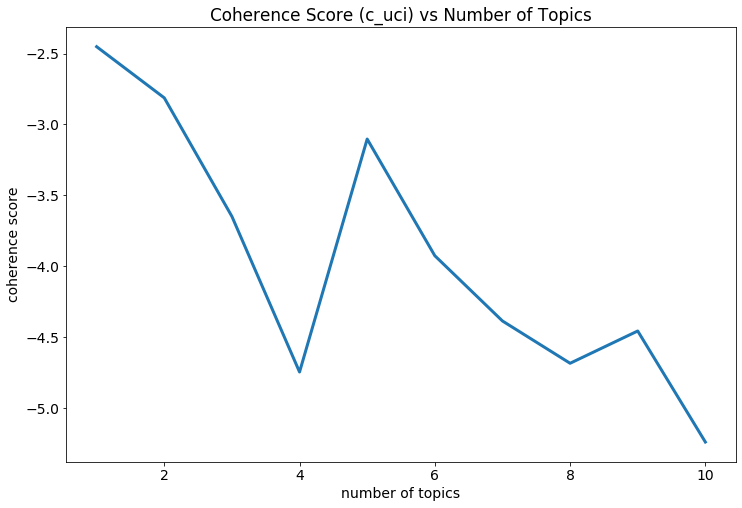

In [28]:
drugs_call_coherence_cuci = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                              drugs_calltaker['sop'], coherence = 'c_uci')
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.plot(drugs_call_coherence_cuci.loc[:, 'num_topic'].values, 
        drugs_call_coherence_cuci.loc[:, 'coherence_score'].values)
ax.set_xlabel('number of topics')
ax.set_ylabel('coherence score')
ax.set_title('Coherence Score (c_uci) vs Number of Topics')
plt.show()

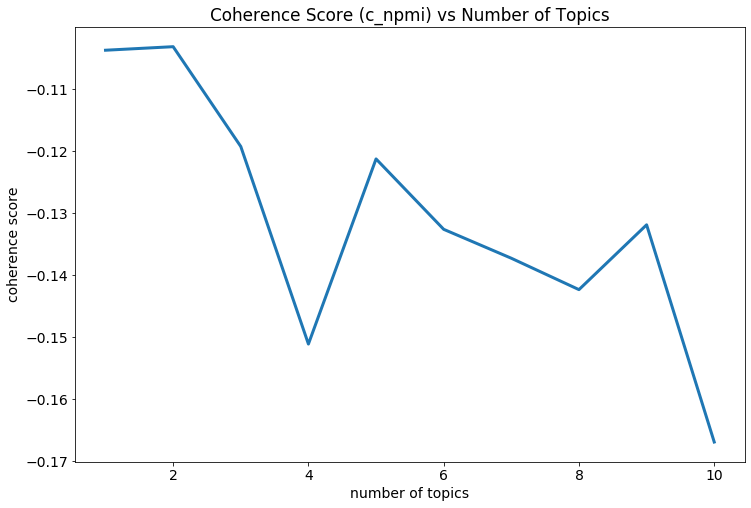

In [29]:
drugs_call_coherence_cnpmi = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                        drugs_calltaker['sop'], coherence = 'c_npmi')
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.plot(drugs_call_coherence_cnpmi.loc[:, 'num_topic'].values, 
        drugs_call_coherence_cnpmi.loc[:, 'coherence_score'].values)
ax.set_xlabel('number of topics')
ax.set_ylabel('coherence score')
ax.set_title('Coherence Score (c_npmi) vs Number of Topics')
plt.show()

#### Reflection of DRUGS coherence score
- the coherence score is very high for the one-topic model
- this makes sense, because we are looking at docs under the same type "DRUGS"

#### Question
- While the model assigns the documents with the correct topic, does this necessarily mean the documents are similar enough to be consolicated?
- LDA in not stable.  How will this instability affect us?

In [30]:
# os.listdir('.')

In [31]:
# json_dir = '../data/interim'
# os.chdir(json_dir)
# all_sop = os.listdir('.')
# print(all_sop)

In [32]:
# def load_sop_json(filename):
#     cwd = os.getcwd()
#     os.chdir(notebook_dir)
#     with open(f'../data/interim/{filename}') as f:
#         one_type = json.load(f)
#     f.close()
#     os.chdir(cwd)
#     return one_type

In [33]:
# juris_all, roles_all, sops_all = list(), list(), list()
# for filename in all_sop:
#     one_type = load_sop_json(filename)
#     for juri, dct in one_type.items():
#         for role, sop in dct.items():
#             juris_all.append(juri)
#             roles_all.append(role)
#             sops_all.append(sop)
# alldf = pd.DataFrame({'juri': juris_all, 'role': roles_all, 'sop': sops_all})
# alldf

In [34]:
# alldf.iloc[0, :]['sop']

In [35]:
# dt_matrix_all, corpus_all, dictionary_all = get_dct_dtmatrix(sops_all)

In [36]:
# all_coherence = topics_with_coherence(dt_matrix_all, corpus_all, dictionary_all, N = 20)

In [37]:
# all_coherence

In [38]:
# plt.figure(figsize = (12, 8))
# plt.plot(all_coherence.loc[:, 'num_topic'].values, all_coherence.loc[:, 'coherence_score'].values)
# plt.show()